In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os, sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from imview.lib import pltlib

from osgeo import gdal
from pygeotools.lib import iolib, geolib, malib

import geopandas as gpd
import cartopy.crs as ccrs 

pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def cartopy_extent(extent):
    return [extent[0], extent[2], extent[1], extent[3]]

def append_centroid_xy(df):
    xlist = []
    ylist = []
    for index, row in df.centroid.iteritems():
        xlist.append(row.x)
        ylist.append(row.y)
    df['centroid_x'] = xlist
    df['centroid_y'] = ylist

def rms(a):
    return ((a**2).sum())**0.5

In [34]:
#Define aggregation function for the dissolve
def aggregate(glac_df, glac_df_mb, agg_df, col):
    aggfunc = {'area_m2':[np.mean, np.sum], \
               'mb_mwea':[np.mean, np.median, np.std, np.sum, np.size], \
               'mb_mwea_sigma':[np.mean, np.median, rms], \
               'mb_m3wea':[np.mean, np.median, np.sum], \
               'mb_m3wea_sigma':[np.mean, np.median, rms], \
               'mb_Gta':[np.sum], \
               'Area':[np.mean, np.sum], \
               't1':[np.mean, np.min, np.max], \
               't2':[np.mean, np.min, np.max], \
               'dt':[np.mean, np.min, np.max]}
    
    #This is for all glaciers - mostly just to get total area
    glac_df_agg_sum = glac_df.groupby(col).sum()
    glac_df_agg_mean = glac_df.groupby(col).mean()
    #glac_df_agg_mean = glac_df.groupby(col).median()
    #Perform the aggregation
    glac_df_mb_agg = glac_df_mb.groupby(col).agg(aggfunc)
    
    glac_df_mb_agg[('mb_Gta','rms')] = glac_df_mb_agg[('mb_m3wea_sigma', 'rms')]/1E9
    
    #This is count of number of glaciers
    glac_df_mb_agg[('mb_mwea', 'count')] = glac_df_mb_agg[('mb_mwea', 'size')].astype('int64') 
   
    #These are values for all glaciers in each region (not just those with mb numbers)
    glac_df_mb_agg[('Area_all', 'mean')] = glac_df_agg_mean['Area']
    glac_df_mb_agg[('Area_all', 'sum')] = glac_df_agg_sum['Area']
    
    #Percent coverage of mb numbers
    glac_df_mb_agg[('Area','perc')] = 100*glac_df_mb_agg[('Area','sum')]/glac_df_mb_agg[('Area_all', 'sum')]
    glac_df_mb_agg[('mb_mwea', 'total_m3a')] = glac_df_mb_agg[('mb_mwea', 'mean')] * glac_df_mb_agg[('Area_all', 'sum')] * 1E6
    glac_df_mb_agg[('mb_mwea', 'total_Gta')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')]/1E9 
    glac_df_mb_agg[('mb_mwe_cum', 'mean')] = glac_df_mb_agg[('mb_mwea','mean')] * glac_df_mb_agg[('dt', 'mean')]
    glac_df_mb_agg[('mb_mwe_cum', 'total_m3')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('mb_mwe_cum', 'total_Gt')] = glac_df_mb_agg[('mb_mwea', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
   
    #Compute numbers for meltwater (polygons with mb < 0)
    #glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea' < 0]].sum()
    glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea'] < 0].groupby(col).agg(aggfunc)
    glac_df_mb_agg[('meltwater', 'count')] = glac_df_mb_agg_meltwater[('mb_mwea', 'size')].astype('int64') 
    glac_df_mb_agg[('meltwater', 'total_m3a')] = glac_df_mb_agg_meltwater[('mb_m3wea', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_Gta')] = glac_df_mb_agg[('meltwater', 'total_m3a')]/1E9 
    glac_df_mb_agg[('meltwater', 'total_mmSLEa')] = glac_df_mb_agg[('meltwater', 'total_Gta')]/Gt2mm
    glac_df_mb_agg[('meltwater_cum', 'total_m3')] = glac_df_mb_agg[('meltwater', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_Gt')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_mmSLE')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    append_centroid_xy(agg_df)
    if 'basin' in col:
        #Preserve basin attributes (endorheic flag, discharge)
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['ENDO', 'centroid_x', 'centroid_y']], left_index=True, right_index=True)
    else:
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['centroid_x', 'centroid_y']], left_index=True, right_index=True)
    glac_df_mb_agg.sort_values(by=('Area_all', 'sum'), ascending=False, inplace=True)
    glac_df_mb_agg.df_name = col
    return glac_df_mb_agg

In [35]:
def add_legend(ax, sf=16, loc='upper right'):
    """
    Create legend for scaled scatterplot markers
    """
    ax.autoscale(False)
    #CONUS
    #leg_s = np.array([0.1, 0.5, 1.0, 5.0, 10.0])
    #HMA
    #leg_s = np.array([0.1, 1.0, 10.0, 100.0])
    leg_s = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])
    #Spoof dummy coordinates way off map
    leg_x = np.full(leg_s.size, -999999999)
    leg_y = np.full(leg_s.size, -999999999)
    for i, s in enumerate(leg_s):
        #lbl = r'$%0.1f\/km^2$' % s
        lbl = '%i' % s
        ax.scatter(leg_x[i], leg_y[i], s=s*sf, c='gray', label=lbl)
    legend = ax.legend(title=r'$Glacier\/Area\/(km^2)$', scatterpoints=1, loc=loc, prop={'size':7}, ncol=leg_s.size)
    legend.get_title().set_fontsize('8')
    return legend

In [64]:
def make_map(mb_dissolve_df=None, glac_df_mb=None, agg_df=None, col=('mb_mwea', 'mean'), border_df=None, crs=None,\
             extent=None, hs=None, hs_extent=None, clim=None, labels='val', title=None):

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_aspect('equal')
    legend = add_legend(ax, sf=scaling_f)
    if title is not None:
        ax.set_title(title)

    if clim is None:
        #clim = (glac_df_mb[col].min(), glac_df_mb[col].max())
        clim = malib.calcperc_sym(mb_dissolve_df[col], perc=(1,99))

    cmap = 'RdBu'
    if 'mb_mwea' in col:
        label = 'Mass Balance (m we/yr)'
    elif 'mb_Gta' in col: 
        label = 'Mass Balance (Gt/yr)'
    elif 'meltwater' in col: 
        label = 'Excess Meltwater Runoff (Gt/yr)'
        #Reverse, as these are negative values
        cmap = 'YlOrRd_r'
        #cmap = 'inferno'
        clim = malib.calcperc(mb_dissolve_df[col], perc=(0,99))
    elif 't1' in col:
        cmap = 'inferno'
        label = 'Source Date (year)'

    #This is cartopy-enabled axes
    #ax = plt.axes(projection=crs)

    #Currently unsupported for AEA
    #gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    if hs is not None:
        print("Plotting image")
        hs_style = {'cmap':'gray', 'origin':'upper', 'extent':cartopy_extent(hs_extent), 'transform':crs}
        ax.imshow(hs, **hs_style)

    if border_df is not None:
        print("Plotting borders")
        border_style = {'facecolor':'0.65','edgecolor':'k', 'linewidth':0.7}
        border_df.plot(ax=ax, **border_style)

    if agg_df is not None:
        print("Plotting agg boundaries")
        #This was to get colored regions
        #agg_style = {'cmap':'cpt_rainbow', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
        agg_style = {'cmap':'summer', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
        #agg_style = {'facecolor':'0.95','edgecolor':'k', 'linewidth':0.3, 'alpha':0.2}
        agg_df.plot(ax=ax, **agg_style)

    if glac_df_mb is not None:
        print("Plotting glacier polygons")
        glac_style = {'edgecolor':'k', 'linewidth':0.1, 'alpha':0.3}
        #This plots mb color ramp for each glacier polygon
        #glac_ax = glac_df_mb.plot(ax=ax, column=col[0], cmap=cmap, vmin=clim[0], vmax=clim[1], **glac_style)
        #This plots outlines
        glac_ax = glac_df_mb.plot(ax=ax, facecolor='none', **glac_style)

    if agg_df is not None:
        agg_style = {'facecolor':'none', 'edgecolor':'w', 'linewidth':0.5}
        agg_df.plot(ax=ax, **agg_style)

    #https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    # fake up the array of the scalar mappable so we can plot colorbar. Urgh...
    sc = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
    sc._A = []

    if mb_dissolve_df is not None:
        print("Plotting scatterplot of %s values" % (col, ))
        #Plot single values for region or basin
        x = mb_dissolve_df['centroid_x']
        y = mb_dissolve_df['centroid_y']
        #Scale by total glacier area in each polygon 
        s = scaling_f*mb_dissolve_df[('Area_all', 'sum')]
        c = mb_dissolve_df[col]
        sc_style = {'cmap':cmap, 'edgecolor':'k', 'linewidth':0.5, 'alpha':0.8}
        sc = ax.scatter(x, y, s, c, vmin=clim[0], vmax=clim[1], **sc_style) 
        #Add labels
        text_kw = {'family':'sans-serif', 'fontsize':10, 'color':'k'}
        if labels is not None:
            print("Adding annotations")
            for k, v in mb_dissolve_df.iterrows():
                #lbl = '%0.2f +/- %0.2f' % (v[col], v[(col[0]+'_sigma',col[1])])
                if labels == 'name+val':
                    lbl = '%s\n%+0.2f' % (k, v[col])
                else:
                    lbl = '%+0.2f' % v[col]
                #ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), xytext=(1,0), textcoords='offset points', family='sans-serif', fontsize=6, color='darkgreen')
                txt = ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), ha='center', va='center', **text_kw)
                txt.set_path_effects([path_effects.Stroke(linewidth=0.75, foreground='w'),path_effects.Normal()])

    #This is minx, miny, maxx, maxy
    if extent is None:
        #if glac_df_mb is not None:
        #    extent = glac_df_mb.total_bounds
        #else:
        extent = mb_dissolve_df.total_bounds

    #For cartopy axes
    #ax.set_extent(cartopy_extent(extent), crs=crs)
    #Pad extent so labels fit within map
    #extent = geolib.pad_extent(extent, perc=0.01, uniform=True)
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])

    #Adding colorbar doesn't work with the cartopy axes
    pltlib.add_cbar(ax, sc, arr=mb_dissolve_df[col], label=label, clim=clim)
    pltlib.add_scalebar(ax, res=1)
    pltlib.hide_ticks(ax)

    plt.tight_layout()

    return fig

In [37]:
site = 'hma'
#site = 'conus'

area_filter = False
min_area_m2 = 1E6

outlier_removal = False

#Ocean area
#3.625×108 km2 (Cogley et al., 2011)
Gt2mm = 362.5

plot = True 
map_plots = True 

#Default mb clim
#mb_clim = (-1.0, 1.0)
#mb_clim = (-1.2, 1.2)
mb_clim = (-0.75, 0.75)

#suptitle = "Glacier Mass Balance (ASTER 2000–2009)"
suptitle = "Glacier Mass Balance (ASTER+WV/GE 2000–2018)"
#suptitle = "Glacier Mass Balance (ASTER 2009–2018)"
#suptitle = "Glacier Mass Balance (SRTM 2000 to WV/GE median)"

#HMA
scaling_f = 0.2 
#CONUS
#scaling_f = 3 

rgi_col = 'RGIId'
kaab_region_col = 'kaab_region'
region_col = 'himap_region'
basin_col = 'HYBAS_ID'
qdgc_col = 'qdgc'
mascon_col = 'mascon'

extent = None
crs = None
if site == 'hma':
    basin_col = 'basin_name'
    hs_fn = '/Users/dshean/Documents/UW/HMA/mos/hma_mos_32m_20180723/hma_mos_32m_100m_hs_az315.tif'
    glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea.shp'
    #glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea_0.1km.shp'
    #glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_HMA_aea_1km.shp'
    border_shp_fn = '/Users/dshean/data/NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_0_countries_lakes.shp'
    #basin_shp_fn = '/Users/dshean/data/HydroBASINS/hybas_lake_as_lev01-12_v1c/hybas_lake_as_lev04_v1c.shp'
    basin_shp_fn = '/Users/dshean/data/HydroBASINS/HiMAT_full_210_IDs_subset_merged_clip_names_update.gpkg'
    #region_shp_fn = '/Users/dshean/Documents/UW/HMA/Kaab_regions/regions_from_kaab2015_merged_clean.shp'
    kaab_region_shp_fn = '/Users/dshean/data/Kaab_regions/regions_from_kaab2015_merged_clean_20181111.gpkg'
    region_shp_fn = '/Users/dshean/data/himap_regions/boundary_mountain_regions_hma_v3_clean.gpkg'
    #http://www.mindland.com/wp/download-qdgc-continents/
    qdgc_shp_fn = '/Users/dshean/data/qdgc/qdgc_asia/qdgc_01_asia.shp'
    mascon_shp_fn = '/Users/dshean/data/grace_mascons/GSFC.glb.200301_201607_v02.4_clip.gpkg'
    #This is geopandas crs format
    glac_crs = {u'datum':u'WGS84',u'lat_0':36,u'lat_1':25,u'lat_2':47,u'lon_0':85,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #minx, miny, maxx, maxy
    extent = [-1610900, -1142400, 1767400, 1145700]
elif site == 'conus':
    #hs_fn = '/scr/mb/gpd/conus_20171018_mos_32m_trans_100m_hs_az315_1km.tif'
    glac_shp_fn = '/Users/dshean/data/rgi60/regions/rgi60_merge_CONUS_aea.shp'
    #region_shp_fn = '/Users/dshean/Documents/UW/CONUS/regions/conus_mb_regions.shp'
    region_shp_fn = '/Users/dshean/data/CONUS/regions/conus_mb_regions_aea.shp'
    border_shp_fn = '/Users/dshean/data/NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lakes.shp'
    basin_shp_fn = '/Users/dshean/data/HydroBASINS/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev07_v1c.shp'
    glac_crs = {u'datum':u'WGS84',u'lat_0':43,u'lat_1':36,u'lat_2':49,u'lon_0':-115,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #This is cartopy
    crs = ccrs.AlbersEqualArea(central_longitude=-115, central_latitude=43, standard_parallels=(36, 49))
    extent = [-856800, -789000, 910700, 839400]
else:
    sys.exit("Site not currently supported")

In [38]:
#Input csv from mb_parallel.py
#mb_csv_fn = sys.argv[1]
#mb_csv_fn = "/scr/hma/mb_20181108/ASTER_2000-2018/hma_mb_20181108_0454.csv"
#mb_csv_fn = "/scr/hma/mb_20181211/hma_mb_20181211_2117.csv"
#mb_csv_fn = "/scr/hma/mb_20181222/hma_mb_20181211_2117.csv"
mb_csv_fn = "/scr/hma/mb_20190207/hma_mb_20190207_0856.csv"

#driver = 'GeoJSON'
#ext = 'geojson'
#driver = 'ESRI Shapefile'
#ext = 'shp'
driver = 'GPKG'
ext= 'gpkg'

merge_fn = os.path.splitext(mb_csv_fn)[0]+'_'+os.path.splitext(os.path.split(glac_shp_fn)[-1])[0]+'.'+ext

glac_shp_join_fn = os.path.splitext(merge_fn)[0]+'_join.'+ext

if os.path.exists(glac_shp_join_fn):
    print("Loading glacier polygons joined with regions, basins, qdgc, mascons")
    glac_df = gpd.read_file(glac_shp_join_fn)
    #This is a hack, as geojson doesn't properly preserve custom aae proj
    glac_df.crs = glac_crs
else:
    print("Loading glacier polygons")
    glac_df = gpd.read_file(glac_shp_fn)
    glac_df.shape
    glac_df.set_index(rgi_col, inplace=True)
    #Add centroid field - needed for proper partitioning in spatial join
    glac_df['centroid_geom'] = gpd.GeoSeries(glac_df.centroid)
    glac_df['polygon_geom'] = gpd.GeoSeries(glac_df.geometry)
    glac_df.set_geometry('centroid_geom', inplace=True, drop=True)

#Area in km2
#glac_df.geometry.area.sum()/1E6
#glac_df['Area'].sum()

if kaab_region_shp_fn is not None:
    print("Loading Kaab regions")
    kaab_region_df = gpd.read_file(kaab_region_shp_fn)
    #Convert to glac crs
    kaab_region_df = kaab_region_df.to_crs(glac_df.crs)
    kaab_region_df.set_index(kaab_region_col, inplace=True)

if region_shp_fn is not None:
    print("Loading regions")
    region_df = gpd.read_file(region_shp_fn)
    #Convert to glac crs
    region_df = region_df.to_crs(glac_df.crs)
    region_df.set_index(region_col, inplace=True)

if basin_shp_fn is not None:
    print("Loading basins")
    basin_df = gpd.read_file(basin_shp_fn)
    #There are issues with fiona writing large integers in basin IDs, convert to string to be safe
    #The dtype is int64, but finoa writes int32, and they all get truncated to 2147483647
    if basin_col == 'HYBAS_ID':
        for f in ['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS']:
            basin_df[f] = basin_df[f].astype('str')
    #Convert to glac crs
    basin_df = basin_df.to_crs(glac_df.crs)
    basin_df.set_index(basin_col, inplace=True)

if mascon_shp_fn is not None:
    print("Loading mascon")
    mascon_df = gpd.read_file(mascon_shp_fn)
    #Convert to glac crs
    mascon_df = mascon_df.to_crs(glac_df.crs)
    #Add a unique identifier
    mascon_df[mascon_col] = mascon_df.lat_center.map('{:,.0f}N'.format) + mascon_df.lon_center.map('{:,.0f}E'.format)
    mascon_df.set_index(mascon_col, inplace=True)

if qdgc_shp_fn is not None:
    print("Loading qdgc")
    qdgc_df = gpd.read_file(qdgc_shp_fn)
    #Convert to glac crs
    qdgc_df = qdgc_df.to_crs(glac_df.crs)
    qdgc_df.set_index(qdgc_col, inplace=True)

print(glac_df.shape)
#Add region, basin, etc fields to RGI polygons
if not os.path.exists(glac_shp_join_fn):
    if mascon_shp_fn is not None:
        print("One-time spatial join by mascon")
        glac_df = gpd.sjoin(glac_df, mascon_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':mascon_col}, inplace=True)
        print(glac_df.shape)

    if qdgc_shp_fn is not None:
        print("One-time spatial join by qdgc")
        glac_df = gpd.sjoin(glac_df, qdgc_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':qdgc_col}, inplace=True)
        print(glac_df.shape)

    if kaab_region_shp_fn is not None:
        print("One-time spatial join by Kaab region")
        glac_df = gpd.sjoin(glac_df, kaab_region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':kaab_region_col}, inplace=True)
        print(glac_df.shape)
        
    if region_shp_fn is not None:
        print("One-time spatial join by region")
        glac_df = gpd.sjoin(glac_df, region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':region_col}, inplace=True)
        print(glac_df.shape)

    if basin_shp_fn is not None:
        print("One-time spatial join by basin")
        glac_df = gpd.sjoin(glac_df, basin_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':basin_col}, inplace=True)
        print(glac_df.shape)

    glac_df.set_geometry('polygon_geom', inplace=True, drop=True)
    print("Writing out: %s" % glac_shp_join_fn)
    #With index set to RGIId, it is not written out, hack to create new column
    glac_df.reset_index().rename(columns={'index':rgi_col}).to_file(glac_shp_join_fn, driver=driver)

Loading glacier polygons joined with regions, basins, qdgc, mascons
Loading Kaab regions
Loading regions
Loading basins
Loading mascon
Loading qdgc
(94827, 42)


In [39]:
rgi_count = 95608 - 72 #some RGI 10 included
rgi_count

95536

In [40]:
print("Loading mb")
mb_df = pd.read_csv(mb_csv_fn)
mb_df[rgi_col] = 'RGI60-'+mb_df[rgi_col].map('{:08.5f}'.format)
mb_df.set_index(rgi_col, inplace=True)
mb_df['mb_Gta'] = mb_df['mb_m3wea']/1E9
mb_df_t1 = mb_df['t1'].mean()
mb_df_t2 = mb_df['t2'].mean()
print(mb_df_t1, mb_df_t2)
dt_str = '%.0f-%.0f' % (mb_df_t1, mb_df_t2)

#mb_df['mb_mwea_area'] = mb_df['mb_mwea'] * mb_df['area_km2']*1E6

if os.path.exists(merge_fn):
    print("Loading merged polygons and mb")
    glac_df_mb = gpd.read_file(merge_fn)
    glac_df_mb.set_index(rgi_col, inplace=True)
    print(glac_df_mb.shape)
else:
    print("Merging glacier polygons and mb results")
    glac_df_mb = glac_df.merge(mb_df, left_index=True, right_index=True)
    #With index set to RGIId, it is not written out, hack to create new column
    print(glac_df_mb.shape)
    print("Writing out: %s" % merge_fn)
    glac_df_mb.reset_index().rename(columns={'index':rgi_col}).to_file(merge_fn, driver=driver)

print("%i merged records loaded" % (glac_df_mb.shape[0]))

if area_filter:
    print("Filtering by glacier polygon area (min %0.2f km^2)" % (min_area_m2/1E6))
    orig_count = glac_df_mb.shape[0]
    glac_df_mb = glac_df_mb[glac_df_mb['area_m2'] > min_area_m2]
    print("%i of %i records preserved" % (glac_df_mb.shape[0], orig_count))

Loading mb
2000.4119999999998 2018.4119999999998
Loading merged polygons and mb
(94553, 66)
94553 merged records loaded


In [41]:
rgi_count_perc = 100.*glac_df_mb.shape[0]/rgi_count
print("%i of %i total RGI polygons: %0.2f%%" % (glac_df_mb.shape[0], rgi_count, rgi_count_perc))

94553 of 95536 total RGI polygons: 98.97%


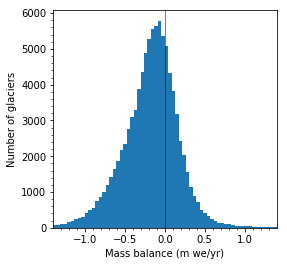

In [58]:
f, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('Mass balance (m we/yr)')
ax.set_ylabel('Number of glaciers')
hist_clim = (-1.4, 1.4)
ax.set_xlim(*hist_clim)
glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=64, grid=False)
ax.axvline(0, lw=0.5, color='k')
ax.minorticks_on()

In [43]:
if outlier_removal:
    print("Removing outliers")

    #outlier_perc = (0.01, 0.99)
    outlier_perc = (0.001, 0.999)
    #outlier_clim = (glac_df_mb['mb_mwea'].quantile(outlier_perc[0]), glac_df_mb['mb_mwea'].quantile(outlier_perc[1]))
    std_f = 3.5
    #outlier_clim = glac_df_mb['mb_mwea'].mean() - std_f*glac_df_mb['mb_mwea'].std()
    outlier_clim = glac_df_mb['mb_mwea'].median() - std_f*malib.mad(glac_df_mb['mb_mwea'].values)
    outlier_clim = (outlier_clim, -outlier_clim)
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    #inlier_idx = np.abs(glac_df_mb['mb_mwea'] - glac_df_mb['mb_mwea'].mean()) <= (3*glac_df_mb['mb_mwea'].std())
    inlier_idx = (glac_df_mb['mb_mwea'] >= outlier_clim[0]) & (glac_df_mb['mb_mwea'] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb.shape[0]))
    glac_df_mb = glac_df_mb[inlier_idx]
    print("%i records after outlier removal" % (glac_df_mb.shape[0]))

    if False:
        glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=256, label='After outlier filter')
        ax.axvline(0, linewidth=0.5, color='k')
        ax.legend()

In [44]:
glac_df_mb.columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'mascon', 'area_deg', 'area_km2', 'basin', 'elev_flag', 'lat_center',
       'lat_span', 'location', 'lon_center', 'lon_span', 'qdgc', 'lat', 'lon',
       'areakm2', 'kaab_region', 'himap_region', 'basin_name', 'DN', 'ENDO',
       'x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect', 'dhdt_ma',
       'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2', 'mb_m3wea',
       'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc', 'H_m',
       'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma', 'mb_Gta',
       'geometry'],
      dtype='object')

In [45]:
glac_df_mb['area_m2'].mean()


1026181.4244163592

In [46]:
if kaab_region_shp_fn is not None:
    glac_df_mb_kaab_region = aggregate(glac_df, glac_df_mb, kaab_region_df, kaab_region_col)

In [47]:
if region_shp_fn is not None:
    glac_df_mb_region = aggregate(glac_df, glac_df_mb, region_df, region_col)

In [48]:
glac_df_mb_kaab_region.iloc[1]

(area_m2, mean)                        766,321.36
(area_m2, sum)                  13,504,115,008.04
(mb_mwea, mean)                             -0.20
(mb_mwea, median)                           -0.17
(mb_mwea, std)                               0.30
(mb_mwea, sum)                          -3,564.59
(mb_mwea, size)                         17,622.00
(mb_mwea_sigma, mean)                        0.28
(mb_mwea_sigma, median)                      0.23
(mb_mwea_sigma, rms)                        44.10
(mb_m3wea, mean)                      -171,326.04
(mb_m3wea, median)                     -23,500.55
(mb_m3wea, sum)                 -3,019,107,399.09
(mb_m3wea_sigma, mean)                 181,199.83
(mb_m3wea_sigma, median)                43,179.97
(mb_m3wea_sigma, rms)               96,190,225.78
(mb_Gta, sum)                               -3.02
(Area, mean)                                 0.77
(Area, sum)                             13,504.09
(t1, mean)                               2,000.41


In [49]:
glac_df_mb_kaab_region[[('Area_all', 'sum'),('mb_Gta', 'sum'),('mb_Gta', 'rms')]]

,"(Area_all, sum)","(mb_Gta, sum)","(mb_Gta, rms)"
kaab_region,,,
Karakoram,"20,237.82",-0.81,0.70
Inner TP,"13,536.96",-3.02,0.10
Tien Shan,"12,099.78",-3.53,0.38
Kunlun,"10,419.00",0.49,0.19
Spiti Lahaul,"7,743.00",-2.46,0.10
Pamir,"7,097.66",-0.80,0.22
Nyainqentangla,"6,944.06",-3.51,0.21
Hindu Kush,"5,324.42",-0.45,0.11
Central Himalaya,"4,969.56",-1.81,0.11


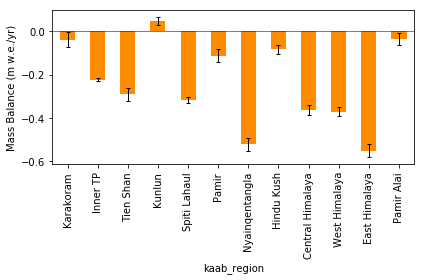

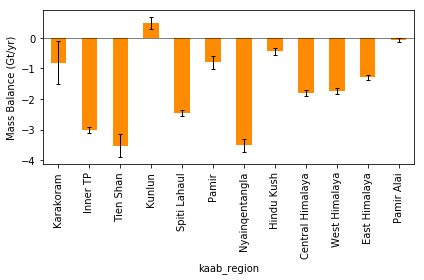

In [50]:
%matplotlib inline
fig, ax = plt.subplots()
(glac_df_mb_kaab_region[('mb_m3wea', 'sum')]/glac_df_mb_kaab_region[('area_m2', 'sum')]).plot.bar(yerr=glac_df_mb_kaab_region[('mb_m3wea_sigma', 'rms')]/glac_df_mb_kaab_region[('area_m2', 'sum')], ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (m w.e./yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwea_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

fig, ax = plt.subplots()
(glac_df_mb_kaab_region[('mb_m3wea', 'sum')]/1E9).plot.bar(yerr=glac_df_mb_kaab_region[('mb_m3wea_sigma', 'rms')]/1E9, ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (Gt/yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gta_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

In [51]:
if mascon_shp_fn is not None:
    glac_df_mb_mascon = aggregate(glac_df, glac_df_mb, mascon_df, mascon_col)

if qdgc_shp_fn is not None:
    glac_df_mb_qdgc = aggregate(glac_df, glac_df_mb, qdgc_df, qdgc_col)

if basin_shp_fn is not None:
    glac_df_mb_basin = aggregate(glac_df, glac_df_mb, basin_df, basin_col)
    glac_df_mb_basin_exo = glac_df_mb_basin[glac_df_mb_basin['ENDO'] == 0]

In [52]:
#Compile stats for all glaciers
#specific mass balance rate and total mass change  
all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].mean()
#all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].median()
all_stats['mb_mwea_std'] = glac_df_mb[['mb_mwea','mb_mwea']].std()
all_stats['mb_m3wea_std'] = glac_df_mb[['mb_mwea','mb_m3wea']].std()
#glac_df_mb[['mb_mwea','mb_m3wea']].apply(malib.mad, axis=0)
#all_stats = glac_df_mb[['mb_mwea']].mean()
#Total sampled area
all_stats['sample_area'] = glac_df_mb['Area'].sum()
#All area in RGI db
all_stats['RGI_total_area'] = glac_df['Area'].sum()
all_stats['sample_area_perc'] = all_stats['sample_area']/all_stats['RGI_total_area']
all_stats['mb_m3wea_sum'] = glac_df_mb['mb_m3wea'].sum()
all_stats['mb_m3wea_sigma'] = rms(glac_df_mb['mb_m3wea_sigma'])
all_stats['mb_m3wea_all'] = all_stats['mb_mwea'] * all_stats['RGI_total_area'] * 1E6
all_stats['mb_Gta'] = all_stats['mb_m3wea']/1E9
all_stats['mb_Gta_sum'] = all_stats['mb_m3wea_sum']/1E9
all_stats['mb_Gta_sigma'] = all_stats['mb_m3wea_sigma']/1E9
all_stats['mb_Gta_all'] = all_stats['mb_m3wea_all']/1E9
all_stats['mma_SLR'] = all_stats['mb_Gta_sum']/Gt2mm

print(all_stats['mb_m3wea_sum']/(all_stats['sample_area']*1E6))
print(all_stats['mb_m3wea_sigma']/(all_stats['sample_area']*1E6))

dt = glac_df_mb['dt'].mean()
all_stats_cum = all_stats * dt

print("All glaciers, rate")
print(all_stats)
print("All glaciers, cumulative")
print(all_stats_cum)

-0.19555045252827935
0.009313271231665086
All glaciers, rate
mb_mwea                                                         -0.18
mb_m3wea                                                  -200,670.42
mb_mwea_std              mb_mwea   0.38
mb_mwea   0.38
dtype: float64
mb_m3wea_std        mb_mwea            0.38
mb_m3wea   1,662,914.1...
sample_area                                                 97,028.62
RGI_total_area                                              97,300.12
sample_area_perc                                                 1.00
mb_m3wea_sum                                       -18,973,990,353.64
mb_m3wea_sigma                                         903,653,845.98
mb_m3wea_all                                       -17,651,849,125.58
mb_Gta                                                          -0.00
mb_Gta_sum                                                     -18.97
mb_Gta_sigma                                                     0.90
mb_Gta_all                   

In [53]:
glac_df_mb_kaab_region.columns

Index([             ('area_m2', 'mean'),               ('area_m2', 'sum'),
                    ('mb_mwea', 'mean'),            ('mb_mwea', 'median'),
                     ('mb_mwea', 'std'),               ('mb_mwea', 'sum'),
                    ('mb_mwea', 'size'),        ('mb_mwea_sigma', 'mean'),
            ('mb_mwea_sigma', 'median'),         ('mb_mwea_sigma', 'rms'),
                   ('mb_m3wea', 'mean'),           ('mb_m3wea', 'median'),
                    ('mb_m3wea', 'sum'),       ('mb_m3wea_sigma', 'mean'),
           ('mb_m3wea_sigma', 'median'),        ('mb_m3wea_sigma', 'rms'),
                      ('mb_Gta', 'sum'),                 ('Area', 'mean'),
                        ('Area', 'sum'),                   ('t1', 'mean'),
                         ('t1', 'amin'),                   ('t1', 'amax'),
                         ('t2', 'mean'),                   ('t2', 'amin'),
                         ('t2', 'amax'),                   ('dt', 'mean'),
                         

In [54]:
region_col = [('mb_mwea', 'count'),('mb_mwea', 'mean'),('mb_mwea', 'std'),('Area', 'sum'),('Area_all', 'sum'),('Area', 'perc'),('mb_mwea', 'total_Gta'), ('mb_Gta', 'sum'), ('mb_Gta', 'rms')]

kaab_region_summary = glac_df_mb_kaab_region[region_col]
display(kaab_region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_kaab_region_summary.pkl' % dt_str
kaab_region_summary.to_pickle(out_fn)

region_summary = glac_df_mb_region[region_col]
display(region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_region_summary.pkl' % dt_str
region_summary.to_pickle(out_fn)

basin_summary = glac_df_mb_basin[[('meltwater', 'count'),('meltwater', 'total_m3a'),('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa'), ('Area_all', 'sum')]]
display(basin_summary)
print(glac_df_mb_basin[[('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]].sum())
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_basin_summary.pkl' % dt_str
basin_summary.to_pickle(out_fn)

print("\nExorheic Basins (SLR contribution)")
display(glac_df_mb_basin_exo[[('meltwater', 'count'),('meltwater', 'total_m3a'),('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]])
print(glac_df_mb_basin_exo[[('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]].sum())

#Compile stats for each division
print("\nTotal Gt/a for each aggregation")
print('agg', 'total_Gta', 'mb_mwea')
for i in [glac_df_mb_basin, glac_df_mb_region, glac_df_mb_qdgc]:
    print(i.df_name, i[('mb_Gta', 'sum')].sum(), i['mb_mwea', 'mean'].mean())

if False:
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    print("Loading shaded relief map")
    hs_ds = gdal.Open(hs_fn)
    hs = iolib.ds_getma(hs_ds)
    hs_extent = geolib.ds_extent(hs_ds)
    hs_extent_cartopy = cartopy_extent(hs_extent)
    print("Plotting image")
    ax.imshow(hs, cmap='gray', origin='upper', extent=hs_extent_cartopy, transform=crs, alpha=0.6)
else:
    hs = None

"""
#This is currently broken
import cartopy.feature as cfeature
borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')
ax.add_feature(borders, edgecolor='k')
"""

,"(mb_mwea, count)","(mb_mwea, mean)","(mb_mwea, std)","(Area, sum)","(Area_all, sum)","(Area, perc)","(mb_mwea, total_Gta)","(mb_Gta, sum)","(mb_Gta, rms)"
kaab_region,,,,,,,,,
Karakoram,10316,-0.02,0.30,"20,230.90","20,237.82",99.97,-0.33,-0.81,0.70
Inner TP,17622,-0.20,0.30,"13,504.09","13,536.96",99.76,-2.74,-3.02,0.10
Tien Shan,14320,-0.28,0.42,"12,097.91","12,099.78",99.98,-3.44,-3.53,0.38
Kunlun,6644,0.12,0.23,"10,419.00","10,419.00",100.00,1.20,0.49,0.19
Spiti Lahaul,9959,-0.20,0.26,"7,741.70","7,743.00",99.98,-1.52,-2.46,0.10
Pamir,7082,-0.06,0.20,"7,097.26","7,097.66",99.99,-0.41,-0.80,0.22
Nyainqentangla,7283,-0.46,0.60,"6,728.12","6,944.06",96.89,-3.19,-3.51,0.21
Hindu Kush,7432,-0.05,0.32,"5,324.28","5,324.42",100.00,-0.27,-0.45,0.11
Central Himalaya,3902,-0.36,0.32,"4,960.50","4,969.56",99.82,-1.79,-1.81,0.11


,"(mb_mwea, count)","(mb_mwea, mean)","(mb_mwea, std)","(Area, sum)","(Area_all, sum)","(Area, perc)","(mb_mwea, total_Gta)","(mb_Gta, sum)","(mb_Gta, rms)"
himap_region,,,,,,,,,
Karakoram,11565,-0.00,0.33,"21,468.56","21,475.66",99.97,-0.01,-0.77,0.70
Central Himalaya,7317,-0.35,0.32,"8,658.35","8,668.87",99.88,-3.00,-3.25,0.14
Western Kunlun Shan,5672,0.11,0.22,"8,455.74","8,455.74",100.00,0.95,0.38,0.18
Western Pamir,9084,-0.06,0.20,"8,420.44","8,420.83",100.00,-0.52,-0.96,0.22
Western Himalaya,9845,-0.20,0.27,"7,967.31","7,968.60",99.98,-1.58,-2.54,0.11
Central Tien Shan,5834,-0.20,0.39,"7,269.88","7,270.83",99.99,-1.48,-1.64,0.37
Nyainqentanglha,7255,-0.42,0.59,"6,829.05","7,044.99",96.93,-2.96,-3.33,0.21
Tibetan Interior Mountains,3496,-0.09,0.19,"3,816.98","3,816.98",100.00,-0.35,-0.44,0.05
Eastern Kunlun Shan,3092,-0.02,0.25,"2,995.00","2,995.00",100.00,-0.06,-0.24,0.05


,"(meltwater, count)","(meltwater, total_m3a)","(meltwater, total_Gta)","(meltwater, total_mmSLEa)","(Area_all, sum)"
basin_name,,,,,
Indus,16041,"-4,515,848,629.58",-4.52,-0.01,"27,295.00"
Tarim,7942,"-2,515,155,677.79",-2.52,-0.01,"21,854.22"
Brahmaputra,9772,"-5,347,993,525.64",-5.35,-0.01,"10,367.66"
Amu_Darya,7600,"-1,357,962,178.42",-1.36,-0.00,"10,078.52"
Ganges,6039,"-3,154,084,669.77",-3.15,-0.01,"8,426.07"
Inner_Tibetan_Plateau,3389,"-1,167,810,150.71",-1.17,-0.00,"6,334.99"
Ili,5588,"-1,755,299,945.63",-1.76,-0.00,"4,408.68"
Inner_Tibetan_Plateau_Extended,3123,"-773,968,604.68",-0.77,-0.00,"2,959.07"
Syr_Darya,3053,"-556,010,327.73",-0.56,-0.00,"2,340.81"


(meltwater, total_Gta)      -22.73
(meltwater, total_mmSLEa)    -0.06
dtype: float64

Exorheic Basins (SLR contribution)


,"(meltwater, count)","(meltwater, total_m3a)","(meltwater, total_Gta)","(meltwater, total_mmSLEa)"
basin_name,,,,
Indus,16041,"-4,515,848,629.58",-4.52,-0.01
Brahmaputra,9772,"-5,347,993,525.64",-5.35,-0.01
Ganges,6039,"-3,154,084,669.77",-3.15,-0.01
Yangtze,1368,"-675,729,768.92",-0.68,-0.00
Salween,2105,"-768,392,309.43",-0.77,-0.00
Mekong,324,"-79,020,179.08",-0.08,-0.00
Yellow,110,"-33,357,203.14",-0.03,-0.00
Irrawady,130,"-33,096,493.80",-0.03,-0.00


(meltwater, total_Gta)      -14.61
(meltwater, total_mmSLEa)    -0.04
dtype: float64

Total Gt/a for each aggregation
agg total_Gta mb_mwea
basin_name -18.97399035364402 -0.3025536389805471
himap_region -18.973990353644005 -0.2198253615768697
qdgc -18.973990353644 -0.21811394129570993


"\n#This is currently broken\nimport cartopy.feature as cfeature\nborders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')\nax.add_feature(borders, edgecolor='k')\n"

In [55]:
mascon_df_out = glac_df_mb_mascon[[('mb_mwea','count'),('mb_mwea', 'mean'), ('mb_mwea', 'std'), ('Area','sum'),('mb_Gta', 'sum'), ('Area_all', 'sum'), ('mb_mwea', 'total_Gta')]]
header = ('n_glaciers','mb_mwea_mean','mb_mwea_std','obs_glacier_area_km2','mb_Gta_sum','all_glacier_area_km2','mb_Gta_all')
mascon_csv_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon.csv'
mascon_df_out.to_csv(mascon_csv_fn, float_format='%0.2f',header=header)

In [66]:
map_plots=True

In [67]:
if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

Loading borders


Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_basin_excess_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('meltwater', 'total_Gta') values
Adding annotations
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_basin_excess_Gt_fig.png


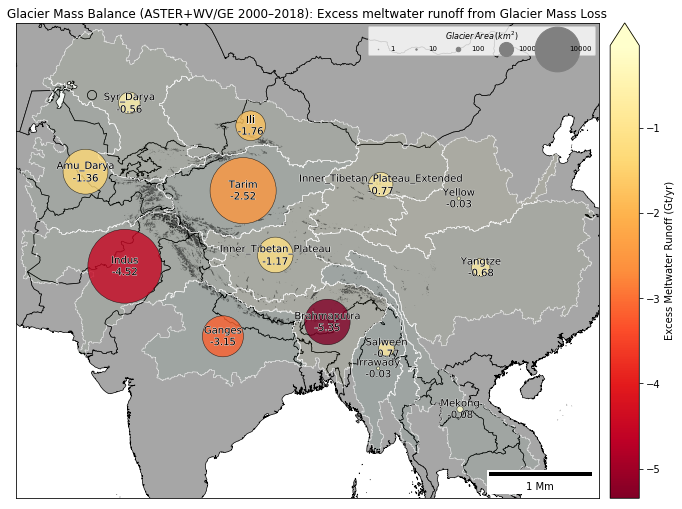

In [68]:
if map_plots and basin_shp_fn is not None:
    basin_melt_gt_clim = (-5, 0)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_excess_Gt_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Excess meltwater runoff from Glacier Mass Loss"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    #basin_extent = basin_df.total_bounds
    basin_fig = make_map(col=('meltwater', 'total_Gta'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_melt_gt_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    #basin_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=None, crs=crs, extent=extent, labels='val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_basin_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_basin_mwe_fig.png


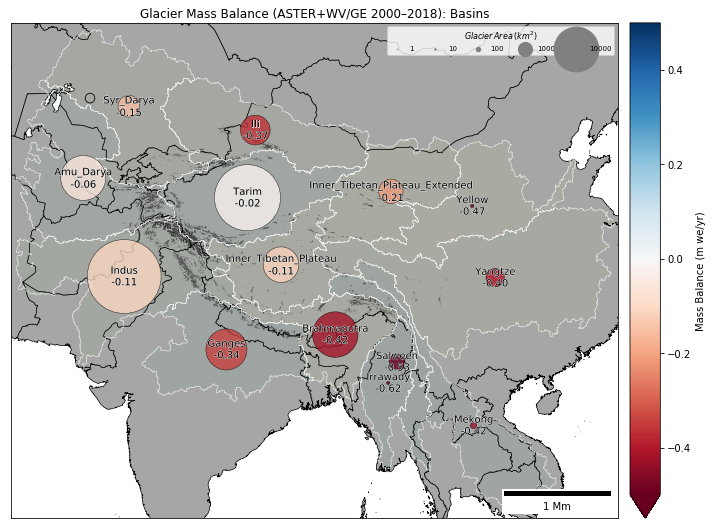

In [69]:
if map_plots and basin_shp_fn is not None:
    basin_mb_clim = (-0.5, 0.5)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_mwe_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Basins"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    basin_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_mb_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_qdgc_mwe_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_qdgc_mwe_fig.png


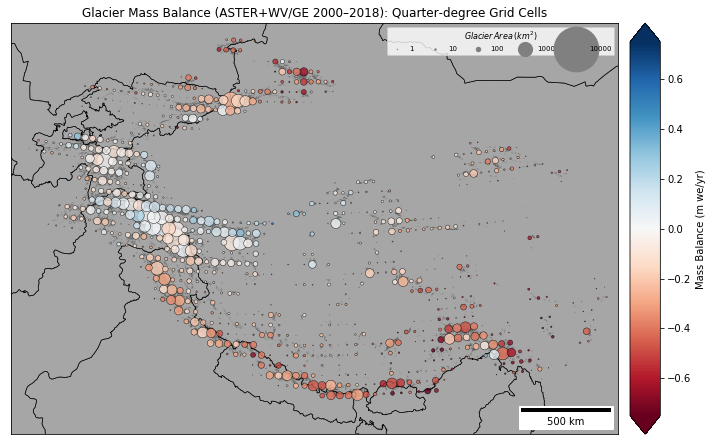

In [70]:
if map_plots and qdgc_shp_fn is not None:
    qdgc_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_qdgc_mwe_fig.png'
    print("Generating figure: %s" % qdgc_fig_fn)
    #To plot grid cells, pass agg_df=qdgc_df
    title = suptitle + ": Quarter-degree Grid Cells"
    qdgc_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_qdgc, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % qdgc_fig_fn)
    qdgc_fig.savefig(qdgc_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_kaab_region_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Adding annotations
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_kaab_region_Gt_fig.png
Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_kaab_region_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_kaab_region_mwe_fig.png


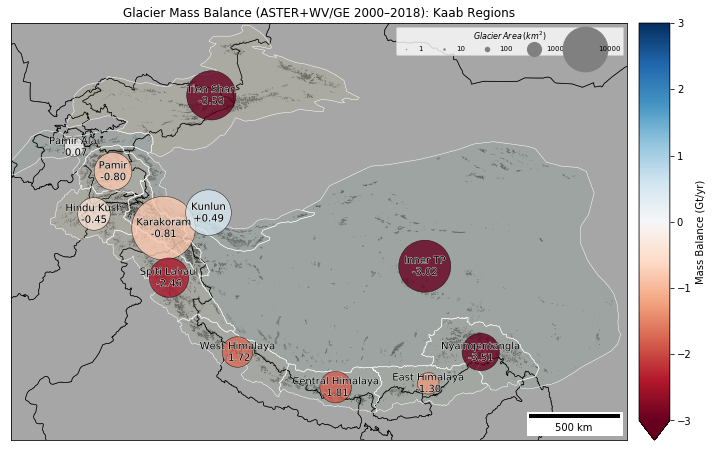

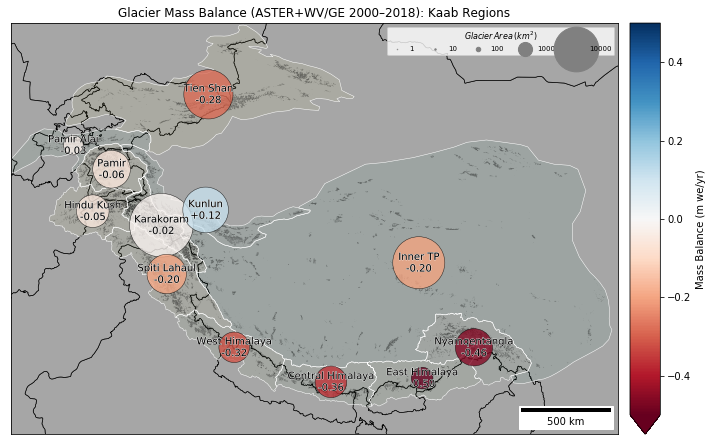

In [71]:
region_gt_clim = (-3.0, 3.0)
region_mb_clim=(-0.5, 0.5)

if map_plots and kaab_region_shp_fn is not None:
    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gt_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwe_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_region_Gt_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Adding annotations
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_region_Gt_fig.png
Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_region_mwe_fig.png
Plotting borders
Plotting agg boundaries
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Adding annotations
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_region_mwe_fig.png


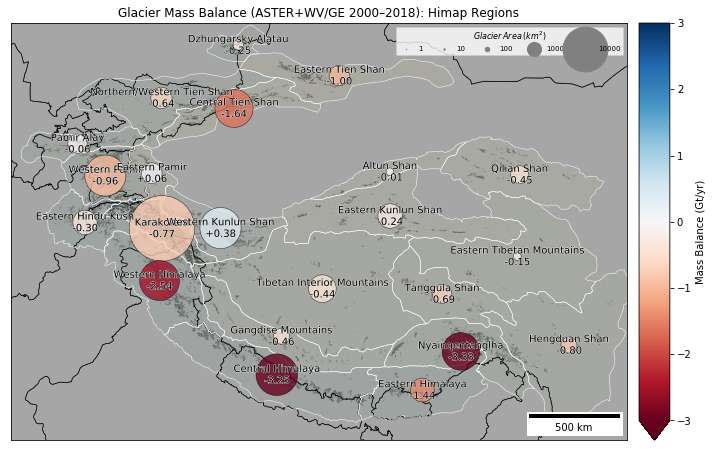

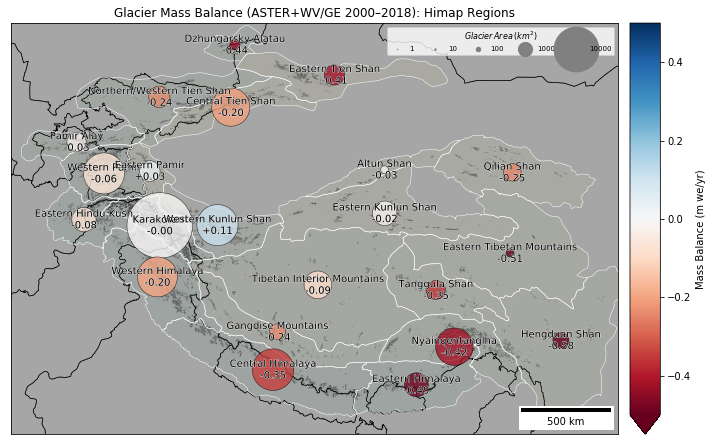

In [72]:
if map_plots and region_shp_fn is not None:
    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_Gt_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_mwe_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_mascon_mwe_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_mwea', 'mean') values
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_mascon_mwe_fig.png


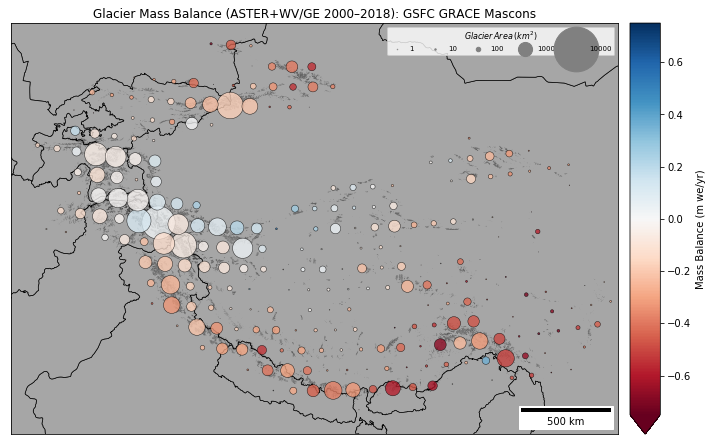

In [73]:
if map_plots and mascon_shp_fn is not None:
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_mwe_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 

Generating figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_mascon_Gt_fig.png
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum') values
Saving figure: /scr/hma/mb_20190207/hma_mb_20190207_0856_rgi60_merge_HMA_aea_join_mascon_Gt_fig.png


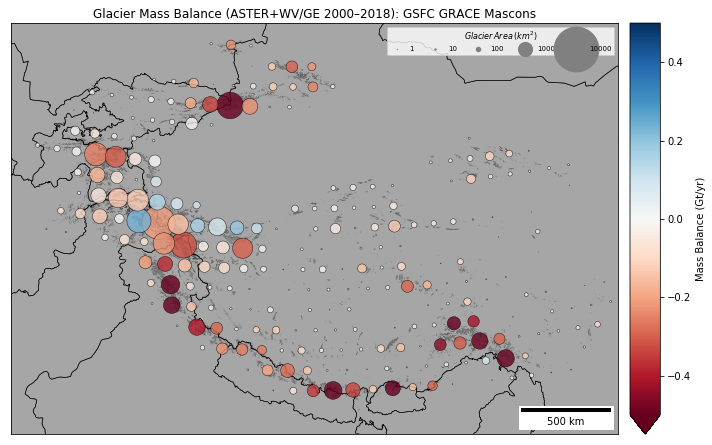

In [74]:
if map_plots and mascon_shp_fn is not None:
    mascon_gt_clim = (-0.5, 0.5)
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_Gt_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mascon_gt_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, dpi=300, bbox_inches='tight', pad_inches=0) 